<a href="https://colab.research.google.com/github/ranton256/cs583_final_project_classify/blob/main/cs583_final_project_classifier_custom_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a final project for CS 583, Drexel Computer Vision
Richard Anton rna63@drexel.edu

See the project readme for more information at:

https://github.com/ranton256/cs583_final_project_classify/blob/main/README.md



In [1]:
!pip install livelossplot --quiet

In [2]:
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
!wget https://image-net.org/data/tiny-imagenet-200.zip

--2021-06-04 02:18:09--  https://image-net.org/data/tiny-imagenet-200.zip
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip.2’

tiny-imagenet-200.z 100%[===================>] 236.61M  46.3MB/s    in 5.1s    

2021-06-04 02:18:14 (46.7 MB/s) - ‘tiny-imagenet-200.zip.2’ saved [248100043/248100043]



In [5]:
!rm -Rf tiny-imagenet-200/
!unzip tiny-imagenet-200.zip


Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [6]:
!ls tiny-imagenet-200/

test  train  val  wnids.txt  words.txt


In [7]:
#  careful...
!rm -Rf cs583_final_project_classify
# git[sic] a fresh copy.
!git clone https://github.com/ranton256/cs583_final_project_classify.git


Cloning into 'cs583_final_project_classify'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 119 (delta 58), reused 78 (delta 27), pack-reused 0
Receiving objects: 100% (119/119), 1.88 MiB | 8.18 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [8]:
from cs583_final_project_classify import make_subset

original_data_dir = "tiny-imagenet-200"

# This creates a subset of images that are either feline or canine.
make_subset.setup_training_data(original_data_dir)
make_subset.setup_validation_data(original_data_dir)
make_subset.setup_test_data()

Streaming output truncated to the last 5000 lines.
copy tiny-imagenet-200/train/n02099712/images/n02099712_315.JPEG to felines_and_canines/train/canine/n02099712_315.JPEG
copy tiny-imagenet-200/train/n02099712/images/n02099712_45.JPEG to felines_and_canines/train/canine/n02099712_45.JPEG
copy tiny-imagenet-200/train/n02099712/images/n02099712_452.JPEG to felines_and_canines/train/canine/n02099712_452.JPEG
copy tiny-imagenet-200/train/n02099712/images/n02099712_425.JPEG to felines_and_canines/train/canine/n02099712_425.JPEG
copy tiny-imagenet-200/train/n02099712/images/n02099712_358.JPEG to felines_and_canines/train/canine/n02099712_358.JPEG
copy tiny-imagenet-200/train/n02099712/images/n02099712_130.JPEG to felines_and_canines/train/canine/n02099712_130.JPEG
copy tiny-imagenet-200/train/n02099712/images/n02099712_80.JPEG to felines_and_canines/train/canine/n02099712_80.JPEG
copy tiny-imagenet-200/train/n02099712/images/n02099712_5.JPEG to felines_and_canines/train/canine/n02099712_5.JP

In [9]:
!ls felines_and_canines/

test  train  val


In [10]:
from cs583_final_project_classify import training

In [11]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        # re-enabled rotations and colorjitter, with lower bounds.
        transforms.RandomRotation(degrees=30),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'felines_and_canines'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

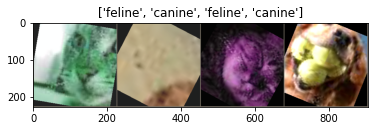

In [12]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

inputs, classes = inputs.to(device), classes.to(device)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

training.imshow(out.cpu(), title=[class_names[x] for x in classes])

In [14]:
pretrained = False

if pretrained:
  # Load the pretrained model from pytorch
  vgg16 = models.vgg16_bn(pretrained=pretrained)

  # freeze all layers
  for param in vgg16.features.parameters():
      param.require_grad = False

else:
  # create a fresh model with VGG16 architecture.
  vgg16 = models.vgg16_bn(pretrained=False)


print(vgg16.classifier[6].out_features) # 1000 

# replace classifier layers
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # strip last layer
features.extend([nn.Linear(num_features, len(class_names))]) ## new last layer
vgg16.classifier = nn.Sequential(*features) # replace classifier in model

# This is how you load a saved model.
#vgg16.load_state_dict(torch.load("../input/vgg16bn/vgg16_bn.pth"))


print(vgg16)

model_ft = vgg16

#criterion = nn.CrossEntropyLoss()
criterion = training.cross_entropy_loss

if torch.cuda.is_available():
  model_ft = model_ft.cuda()
  # No cuda version of custom method.
  #criterion = criterion.cuda()

criterion = training.cross_entropy_loss


#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0003, momentum=0.9, nesterov=False)
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0003, momentum=0.9, nesterov=True)
#optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

optimizer_ft = torch.optim.Adadelta(model_ft.parameters(), lr=0.001, rho=0.9, eps=1e-06, weight_decay=0)

# slowing down LR decay
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=9, gamma=0.03)





1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

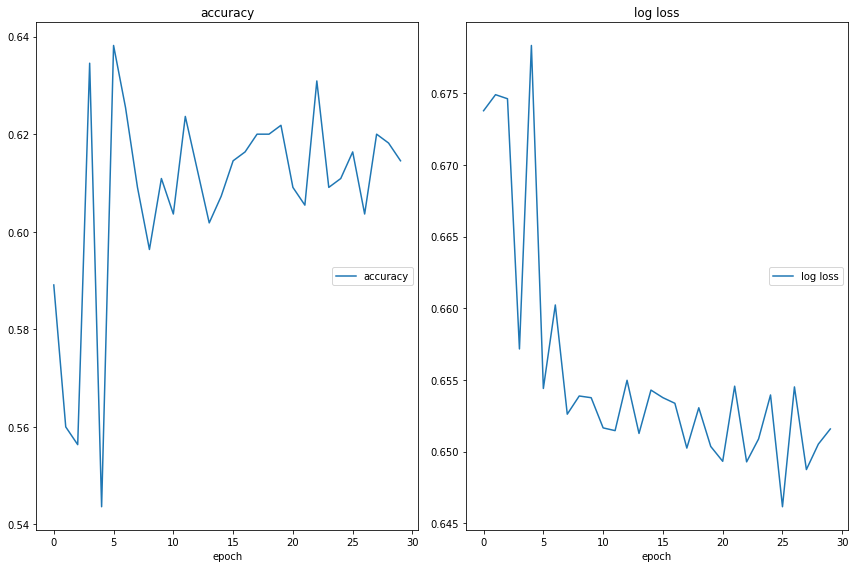

accuracy
	accuracy         	 (min:    0.544, max:    0.638, cur:    0.615)
log loss
	log loss         	 (min:    0.646, max:    0.678, cur:    0.652)
Training complete in 52m 8s
Best val Acc: 0.638182


In [15]:
model_ft = training.train_model(model_ft, dataloaders, dataset_sizes, device, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

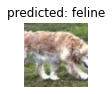

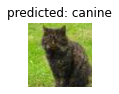

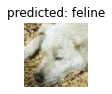

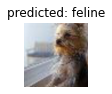

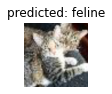

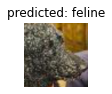

In [16]:
training.visualize_model(model_ft, dataloaders, class_names, device)

In [17]:
training.eval_model_on_test(model_ft, dataloaders, dataset_sizes, device, criterion)

Evaluating model on test dataset
----------
test Loss: 0.6513 Acc: 0.6306



In [18]:
# this will ask you go visit a separate URL to get an authentication token to enter here.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [19]:
import os
model_save_name = input("Enter model filename") 
model_save_name = model_save_name + '.pt'
path = os.path.join(F"/content/gdrive/My Drive/cs583_final_project_models/", model_save_name)
torch.save(model_ft.state_dict(), path)

Enter model filenamescratch_custom_loss1


In [20]:
!ls '/content/gdrive/My Drive/cs583_final_project_models'

adam_from_scratch40t1.pt		  scratch_nesterov1.pt
first_from_scratch.pt			  scratch_sgd1.pt
first_pretrained_classifier.pt		  sgd_pretrained_augmented_sgd.pt
from_scratch_adam_faster_lr_and_gamma.pt  transfer_adadelta1.pt
scratch_adadelta1.pt			  transfer_adadelta2.pt
scratch_adam1.pt			  transfer_adam1.pt
scratch_custom_loss1.pt			  transfer_nesterov1.pt
scratch_extra_augmented1.pt		  transfer_sgd1.pt


## References
* https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
* Very Deep Convolutional Networks for Large-Scale Image Recognition, Karen Simonyan and Andrew Zisserman, 2015, https://arxiv.org/abs/1409.1556
* Tiny imagenet: http://cs231n.stanford.edu/reports/2017/pdfs/935.pdf
* Saving to Google Drive from colab https://medium.com/@ml_kid/how-to-save-our-model-to-google-drive-and-reuse-it-2c1028058cb2
* Keras label names for imagenet: https://github.com/raghakot/keras-vis/blob/master/resources/imagenet_class_index.json

For a complete set of references, see the paper, [Classification using VGG Network and Transfer Learning](https://github.com/ranton256/cs583_final_project_classify/blob/main/paper/Image_Classification_using_VGG_Network_and_Transfer_Learning.pdf)

